In [ ]:
print(backend.defaults().instruction_schedule_map.get('x',(0,)))

Schedule((0, Play(Drag(duration=160, amp=(0.11888062629529902+0j), sigma=40, beta=0.5515719715705902, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")


In [ ]:
print(backend.defaults())

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'u2', 'u3', 'id', 'rz', 'x', 'u1', 'measure'}
  q1: {'sx', 'u2', 'u3', 'id', 'rz', 'x', 'u1', 'measure'}
  q2: {'sx', 'u2', 'u3', 'id', 'rz', 'x', 'u1', 'measure'}
  q3: {'sx', 'u2', 'u3', 'id', 'rz', 'x', 'u1', 'measure'}
  q4: {'sx', 'u2', 'u3', 'id', 'rz', 'x', 'u1', 'measure'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>Qubit Frequencies [GHz]
[5.090215187962305, 5.245528840279351, 5.361492855859864, 5.1703881423849465, 5.254553035940048]
Measurement Frequencies [GHz]
[7.301574705, 7.393433372, 7.360065181, 7.303382327, 7.426223338] )>


# Waveform

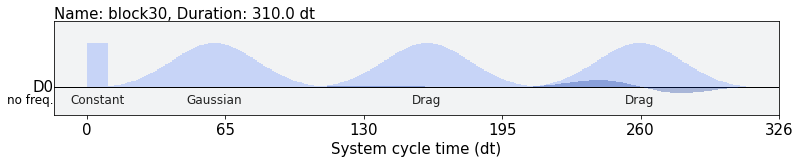

In [33]:
from qiskit import  pulse

d0 = pulse.DriveChannel(0)

with pulse.build() as pulse_prog:
    pulse.play(pulse.Constant(10, 1.0), d0)
    pulse.play(pulse.Gaussian(100, 1.0, 20 ), d0)
    pulse.play(pulse.Drag(100, 1.0, 20, 0.5),d0)
    pulse.play(pulse.Drag(100, 1.0, 20, 5),d0)

pulse_prog.draw()

# Calibrations

In [2]:
import pandas as pd
import numpy as np

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit import IBMQ, schedule


In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_lima')

In [5]:
qubit=0

In [8]:
def setup_cals(backend) -> Calibrations:
    """A function to instantiate calibrations and add a couple of template schedules."""
    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="xm") as xm:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(xp, num_qubits=1)
    cals.add_schedule(xm, num_qubits=1)
    cals.add_schedule(x90p, num_qubits=1)

    return cals

def add_parameter_guesses(cals: Calibrations):
    """Add guesses for the parameter values to the calibrations."""
    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

In [9]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

In [10]:
cals.get_schedule('xp',(0,))

ScheduleBlock(Play(Drag(duration=320, amp=(0.5+0j), sigma=80, beta=0.5), DriveChannel(0)), name="xp", transform=AlignLeft())

In [153]:
print(cals.default_inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'x90p', 'xm', 'xp'}
  q1: {'x90p', 'xm', 'xp'}
  q2: {'x90p', 'xm', 'xp'}
  q3: {'x90p', 'xm', 'xp'}
  q4: {'x90p', 'xm', 'xp'}
Multi qubit instructions:
)>


In [61]:
print(cals.get_inst_map())

<InstructionScheduleMap(1Q instructions:
  q0: {'x90p', 'xm', 'xp'}
  q1: {'x90p', 'xm', 'xp'}
  q2: {'x90p', 'xm', 'xp'}
  q3: {'x90p', 'xm', 'xp'}
  q4: {'x90p', 'xm', 'xp'}
Multi qubit instructions:
)>


In [1]:
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

In [6]:
library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = Calibrations.from_backend(backend, libraries=[library])

In [7]:
print(cals.default_inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'sy', 'y', 'x'}
  q1: {'sx', 'sy', 'y', 'x'}
  q2: {'sx', 'sy', 'y', 'x'}
  q3: {'sx', 'sy', 'y', 'x'}
  q4: {'sx', 'sy', 'y', 'x'}
Multi qubit instructions:
)>


In [8]:
print(cals.get_inst_map())

<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'sy', 'y', 'x'}
  q1: {'sx', 'sy', 'y', 'x'}
  q2: {'sx', 'sy', 'y', 'x'}
  q3: {'sx', 'sy', 'y', 'x'}
  q4: {'sx', 'sy', 'y', 'x'}
Multi qubit instructions:
)>


In [11]:
cals.get_schedule('x',(0,))
cals.get_schedule('y',(0,))

ScheduleBlock(Play(Drag(duration=320, amp=0.5j, sigma=80, beta=0), DriveChannel(0)), name="y", transform=AlignLeft())

#  Finding qubits with spectroscopy

In [13]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal

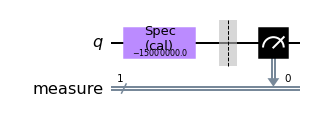

In [14]:
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)
spec = RoughFrequencyCal(qubit, cals, frequencies, backend=backend)
#spec.set_experiment_options(amp=0.005)
circuit = spec.circuits()[0]
circuit.draw(output="mpl")


Schedule((0, ShiftFrequency(-15000000, DriveChannel(0))), (0, Play(GaussianSquare(duration=1072, amp=(0.1+0j), sigma=256.0, width=0.0), DriveChannel(0))), (1072, ShiftFrequency(15000000, DriveChannel(0))), (1072, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (1072, Play(GaussianSquare(duration=22400, amp=(0.008884250867537706-0.023368142556109493j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), name='M_m0')), (23472, Delay(1680, MeasureChannel(0))), name="circuit-122")


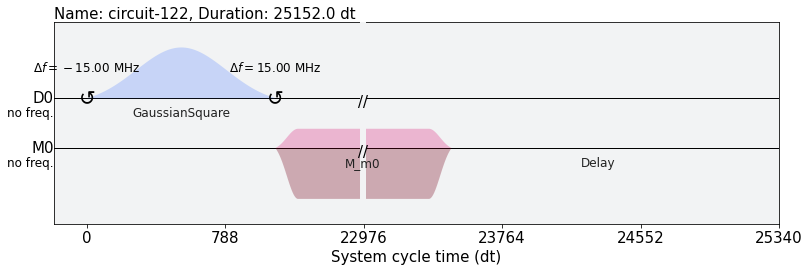

In [16]:
print(schedule(circuit,backend))
schedule(circuit, backend).draw()

In [30]:
spec_data = spec.run().block_for_results()

In [ ]:
spec_data.figure(0)

In [ ]:
print(spec_data.analysis_results("f01"))

# Rabi
### make own calibration -> extract the cal reflected schedule

In [17]:
def setup_cals(backend) -> Calibrations:
    """A function to instantiate calibrations and add a couple of template schedules."""
    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="x") as x:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="sx") as sx:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(x, num_qubits=1)
    cals.add_schedule(sx, num_qubits=1)
    # cals.add_schedule(x90p, num_qubits=1)

    return cals

def add_parameter_guesses(cals: Calibrations):
    """Add guesses for the parameter values to the calibrations."""
    for sched in ["x", "sx"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

cals_rabi = setup_cals(backend)
add_parameter_guesses(cals_rabi)

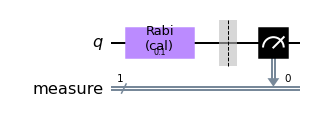

In [21]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal
rabi = RoughXSXAmplitudeCal(qubit, cals_rabi, backend=backend, amplitudes=np.linspace(-0.1, 0.1, 51))
rabi.circuits()[50].draw("mpl")

Schedule((0, Play(Drag(duration=320, amp=(-0.08+0j), sigma=80, beta=0.5), DriveChannel(0))), (320, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (320, Play(GaussianSquare(duration=22400, amp=(0.008884250867537706-0.023368142556109493j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), name='M_m0')), (22720, Delay(1680, MeasureChannel(0))), name="circuit-231")


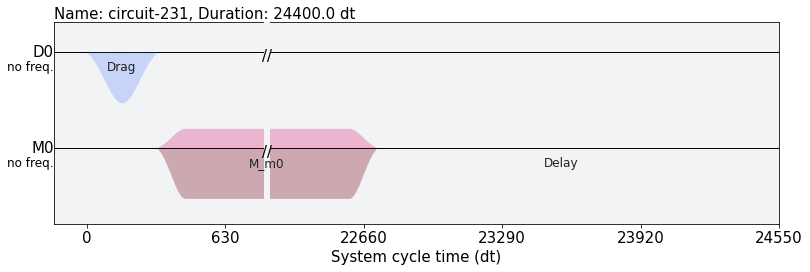

In [22]:
circuit=rabi.circuits()[5]
rabi_sched=schedule(circuit,backend)
print(rabi_sched)
schedule(circuit, backend).draw()

In [54]:
rabi.circuits()[0].calibrations.items()

dict_items([('Rabi', {((0,), (-0.1,)): ScheduleBlock(Play(Drag(duration=320, amp=(-0.1+0j), sigma=80, beta=0.5), DriveChannel(0)), name="x", transform=AlignLeft())})])

### solve the rabi schedule / rabi signal

In [42]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
# dt=0.222
# r = 0.1
# w = 5.03
# drift = 2 * np.pi * w * Z/2
# operators = [2 * np.pi * r * X/2]
# # construct the solver
# solver = Solver(
#     static_hamiltonian=drift,
#     hamiltonian_operators=operators,
#     rotating_frame=drift,
#     rwa_cutoff_freq=2 * 5.0,
#     hamiltonian_channels=['d0'],
#     channel_carrier_freqs={'d0': w},
#     dt=dt
# )
#############################################
# nu_z = 5.03
# nu_x = 1.
# nu_d = 5.029  # Almost on resonance with the Hamiltonian's energy levels difference, nu_z

# X = Operator.from_label('X')
# Y = Operator.from_label('Y')
# Z = Operator.from_label('Z')

# solver = Solver(
#     static_hamiltonian=.5 * 2 * np.pi * nu_z * Z,
#     hamiltonian_operators=[2 * np.pi * nu_x * X],
# )

dt=0.222
r = 0.1
w = 5.03
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]
converter = InstructionToSignals(dt, carriers={"d0": w})
signals = converter.get_signals(rabi_sched)
# construct the solver
solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

In [53]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.quantum_info.states import Statevector
y0 = Statevector([1., 0.])
t_final = .5 / nu_x
n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)
# signals position : either in Signal format or as Qiskit Pulse Schedules
#sol=solver.solve(t_span=[0., 20], y0=y0, signals=[signals[0]], t_eval=t_eval)
sol=solver.solve(t_span=[0., 20], y0=y0, signals=rabi_sched, t_eval=t_eval)

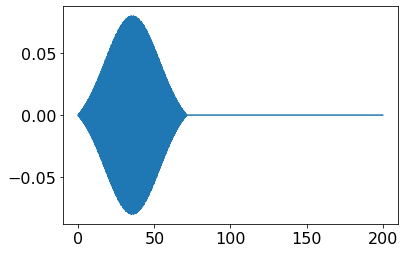

In [45]:
signals[0].draw(0,200, 20000)

In [55]:
for a in signals:
    print(a)

d0
a0
m0


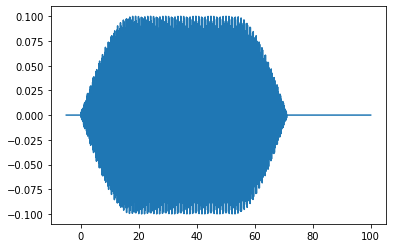

In [114]:
signals[0].draw(-5,100,2000)

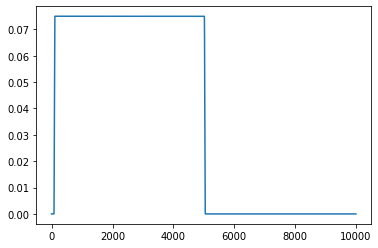

In [70]:
signals[1].draw(-10,10000,20000)

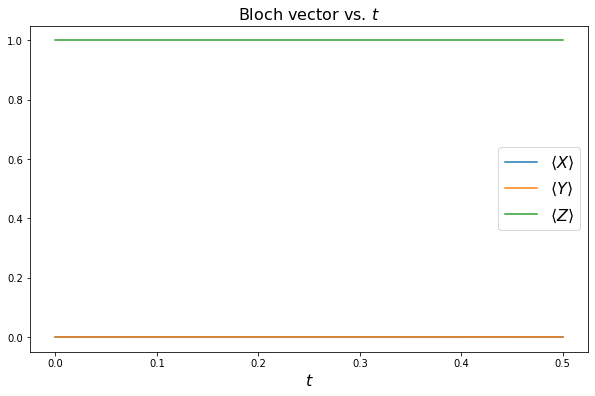

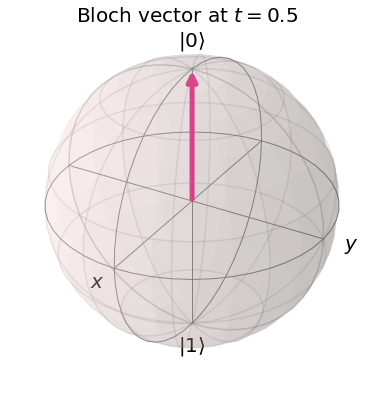

In [46]:
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

def plot_qubit_dynamics(sol, t_eval, X, Y, Z):
    n_times = len(sol.y)
    x_data = np.zeros((n_times,))
    y_data = np.zeros((n_times,))
    z_data = np.zeros((n_times,))

    for t_i, sol_t in enumerate(sol.y):
        x_data[t_i] = sol_t.expectation_value(X).real
        y_data[t_i] = sol_t.expectation_value(Y).real
        z_data[t_i] = sol_t.expectation_value(Z).real

    _, ax = plt.subplots(figsize = (10, 6))
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(t_eval, x_data, label = '$\\langle X \\rangle$')
    plt.plot(t_eval, y_data, label = '$\\langle Y \\rangle$')
    plt.plot(t_eval, z_data, label = '$\\langle Z \\rangle$')
    plt.legend(fontsize = fontsize)
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_title('Bloch vector vs. $t$', fontsize = fontsize)
    plt.show()

    display(plot_bloch_vector([x_data[-1], y_data[-1], z_data[-1]],
                              f'Bloch vector at $t = {t_eval[-1]}$'))

plot_qubit_dynamics(sol, t_eval, X, Y, Z)

In [191]:
rabi_data = rabi.run().block_for_results()

c:\Users\kimje\anaconda3\envs\qiskit_JW\lib\site-packages\numpy\lib\function_base.py:2387: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


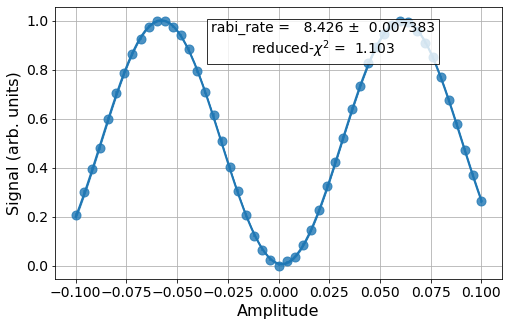

In [192]:
rabi_data.figure(0)

In [193]:
print(rabi_data.analysis_results("rabi_rate"))

AnalysisResult
- name: rabi_rate
- value: 8.426+/-0.007
- χ²: 1.1033915520084614
- quality: good
- device_components: ['Q0']
- verified: False


# Test

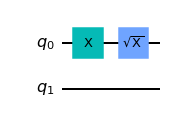

In [24]:
from qiskit import QuantumCircuit


qc=QuantumCircuit(2)
qc.x(0)
qc.sx(0)
qc.draw(output='mpl')

In [25]:
schedule(qc, backend)

Schedule((0, Play(Drag(duration=160, amp=(0.11873415645222593+0j), sigma=40, beta=0.5844951047767629, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), (160, Play(Drag(duration=160, amp=(0.058781893248661406+0.0014192523462371767j), sigma=40, beta=0.6419227422457475, name='X90p_d0'), DriveChannel(0), name='X90p_d0')), name="circuit-328")

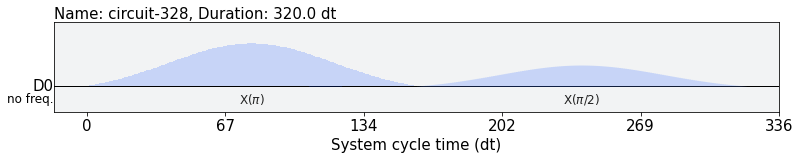

In [26]:
schedule(qc, backend).draw()

In [80]:
qc.calibrations

{}

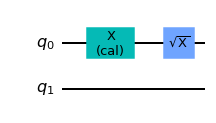

In [27]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia

backend = FakeValencia()

with pulse.build(backend, name='xp') as xp:
    pulse.play(Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0))

qc1=QuantumCircuit(2)
qc1.x(0)
qc1.sx(0)
qc1.add_calibration('x',[0],xp)
qc1.draw(output='mpl')

In [28]:
schedule(qc1,backend)

Schedule((0, Play(Gaussian(duration=128, amp=(0.1+0j), sigma=16), DriveChannel(0))), (128, Play(Drag(duration=160, amp=(0.09618851775276127+0.0008448724348311288j), sigma=40, beta=-0.35835396095069005, name='drag_f8d4'), DriveChannel(0), name='drag_f8d4')), name="circuit-331")

In [54]:
qc1.calibrations.items()

dict_items([('x', {((0,), ()): ScheduleBlock(Play(Gaussian(duration=128, amp=(0.1+0j), sigma=16), DriveChannel(0)), name="xp", transform=AlignLeft())})])

In [56]:
qc1.data

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=())]